In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import time
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import random

def set_random_seed(seed_value=42):
    # Python random seed
    random.seed(seed_value)
    
    # Numpy random seed
    np.random.seed(seed_value)
    
    # PyTorch seed
    torch.manual_seed(seed_value)
    
    # If using CUDA (GPU)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)  # if using multi-GPU
        torch.backends.cudnn.deterministic = True  # For reproducibility
        torch.backends.cudnn.benchmark = False  # Disable auto-optimization for determinism

set_random_seed()

In [2]:
data = pd.read_csv('./microreactor_preprocessed.csv', header="infer")
data

,Unnamed: 0,theta1,theta2,theta3,theta4,theta5,theta6,theta7,theta8,fluxQ1,fluxQ2,fluxQ3,fluxQ4
0,sample_00000,2.237507,-1.698166,2.433453,1.253772,3.140399,-3.082829,2.754851,0.386800,0.248175,0.249199,0.256734,0.245892
1,sample_00000_h,1.253772,2.433453,-1.698166,2.237507,0.386800,2.754851,-3.082829,3.140399,0.249199,0.248175,0.245892,0.256734
2,sample_00000_r,-3.140399,3.082829,-2.754851,-0.386800,-2.237507,1.698166,-2.433453,-1.253772,0.256734,0.245892,0.248175,0.249199
3,sample_00000_v,-0.386800,-2.754851,3.082829,-3.140399,-1.253772,-2.433453,1.698166,-2.237507,0.245892,0.256734,0.249199,0.248175
4,sample_00001,-1.519638,2.489141,-1.853817,1.147173,-2.058398,0.755909,-0.091469,2.379043,0.252723,0.250798,0.248167,0.248312
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999,sample_00817_v,-1.247326,-3.099257,2.267060,-1.909570,-0.263247,-0.705058,2.873758,2.332428,0.251804,0.250008,0.243343,0.254845
3000,sample_00818,-0.075964,1.403187,-2.678154,-0.037988,-1.921514,2.134915,0.195766,3.045334,0.245477,0.249179,0.255498,0.249846
3001,sample_00818_h,-0.037988,-2.678154,1.403187,-0.075964,3.045334,0.195766,2.134915,-1.921514,0.249179,0.245477,0.249846,0.255498
3002,sample_00818_r,1.921514,-2.134915,-0.195766,-3.045334,0.075964,-1.403187,2.678154,0.037988,0.255498,0.249846,0.245477,0.249179


## Data Preprocessing
### 1. Split data
### 2. Scale data (MinMax)
### 3. Convert Numpy arrays to PyTorch tensors
### 4. Place PyTorch tensors in TensorDatasets
### 5. Create Dataloaders with input-output TensorDataset pairs

In [3]:
input_slice = slice(1,9)
output_slice = slice(9, 14)

input = data.iloc[:, input_slice]
output = data.iloc[:, output_slice]

def train_val_test_split(X, y, test_ratio):
    val_ratio = test_ratio / (1 - test_ratio)  # Calculate the ratio of validation to training size
    
    # Step 1: Split the data into (train+val) and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
    
    # Step 2: Split the (train+val) set into actual training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)
    
    return X_train, X_val, X_test, y_train, y_val, y_test  # Return all six sets

# Split data
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(input, output, 0.15)

# Scale data
Xscaler = MinMaxScaler()
Yscaler = MinMaxScaler()

X_train_arr = Xscaler.fit_transform(X_train)
X_val_arr = Xscaler.transform(X_val)
X_test_arr = Xscaler.transform(X_test)

y_train_arr = Yscaler.fit_transform(y_train)
y_val_arr = Yscaler.transform(y_val)
y_test_arr = Yscaler.transform(y_test)

# Convert to tensors
X_train_tensor = torch.tensor(X_train_arr, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_arr, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_arr, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train_arr, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_arr, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_arr, dtype=torch.float32)

# Store as tensor datasets
train = TensorDataset(X_train_tensor, y_train_tensor)
val = TensorDataset(X_val_tensor, y_val_tensor)
test = TensorDataset(X_test_tensor, y_test_tensor)

# Put TensorDatasets in Dataloaders
batch_size = 64
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

# Print to inspect
print(f"Train Tensors (X, y): {X_train_tensor.shape}, {y_train_tensor.shape}")
print(f"Validation Tensor (X, y): {X_val_tensor.shape}, {y_val_tensor.shape}")
print(f"Test Tensor (X, y): {X_test_tensor.shape}, {y_test_tensor.shape}")
print()

for batch_index, (inputs, targets) in enumerate(train_loader):
    print(f"Batch {batch_index+1}")
    print(f"    Input Shape: {inputs.shape}")
    print(f"    Target Shape: {targets.shape}")
    break

Train Tensors (X, y): torch.Size([2102, 8]), torch.Size([2102, 4])
Validation Tensor (X, y): torch.Size([451, 8]), torch.Size([451, 4])
Test Tensor (X, y): torch.Size([451, 8]), torch.Size([451, 4])

Batch 1
    Input Shape: torch.Size([64, 8])
    Target Shape: torch.Size([64, 4])


## Define model architecture

In [4]:
class FNN(nn.Module):
    def __init__(self, in_features, hidden_size1, hidden_size2, out_features, bias=True):
        super(FNN, self).__init__()

        # Input layer
        self.input = nn.Linear(in_features, hidden_size1, bias=bias)

        # FC1
        self.fc1 = nn.Linear(hidden_size1, hidden_size2, bias=bias)
        
        # Final Output Layer
        self.output = nn.Linear(hidden_size2, out_features, bias=bias)

    def forward(self, x):
        # Pass input through the first linear layer
        x = self.input(x)
        x = F.relu(x)  # Apply ReLU activation
        
        # Pass through hidden layer 1
        x = self.fc1(x)
        x = F.relu(x)

        # Pass through hidden layer 2
        x = self.output(x)

        return x

## Build training loop

In [5]:
def train_model(model, train_loader, val_loader, num_epochs, loss_fn, optimizer, device=torch.device('cpu')):
    model.to(device)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0

        # Training loop
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero out the gradients from the optimizer
            optimizer.zero_grad()

            # Forward pass through the model
            outputs = model(inputs)

            # Compute the loss (no KL divergence in standard GRU model)
            loss = loss_fn(outputs, targets)

            # Backward pass to compute gradients
            loss.backward()

            # Optimizer step to update weights
            optimizer.step()

            running_train_loss += loss.item()

        # Compute average training loss
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation loop
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():  # Disable gradient calculation for validation
            for val_inputs, val_targets in val_loader:
                val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)

                # Forward pass on validation data
                val_outputs = model(val_inputs)

                # Compute the validation loss
                val_loss = loss_fn(val_outputs, val_targets)
                running_val_loss += val_loss.item()

        # Compute average validation loss
        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Print progress for each epoch
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    return train_losses, val_losses


# Training visualization function
def plot_losses(train_losses, val_losses, scale='linear', difference=False):
    plt.figure(figsize=(5, 4))
    if difference:
        # Plot the absolute difference between training and validation losses
        loss_diff = np.abs(np.array(train_losses) - np.array(val_losses))
        plt.plot(loss_diff, label="|Training Loss - Validation Loss|")
        plt.xlabel("Epochs")
        plt.ylabel("Absolute Difference in Loss")
        plt.title("Absolute Difference between Training and Validation Loss")
    else:
        # Plot training and validation losses as separate lines
        plt.plot(train_losses, label="Training Loss")
        plt.plot(val_losses, label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss over Epochs")
    
    # Apply scale (e.g., linear or log)
    plt.yscale(scale)
    plt.legend()
    plt.show()

Epoch [1/300], Train Loss: 0.0471, Val Loss: 0.0243
Epoch [2/300], Train Loss: 0.0275, Val Loss: 0.0223
Epoch [3/300], Train Loss: 0.0246, Val Loss: 0.0199
Epoch [4/300], Train Loss: 0.0214, Val Loss: 0.0169
Epoch [5/300], Train Loss: 0.0171, Val Loss: 0.0129
Epoch [6/300], Train Loss: 0.0120, Val Loss: 0.0083
Epoch [7/300], Train Loss: 0.0071, Val Loss: 0.0046
Epoch [8/300], Train Loss: 0.0038, Val Loss: 0.0027
Epoch [9/300], Train Loss: 0.0024, Val Loss: 0.0020
Epoch [10/300], Train Loss: 0.0019, Val Loss: 0.0017
Epoch [11/300], Train Loss: 0.0016, Val Loss: 0.0015
Epoch [12/300], Train Loss: 0.0015, Val Loss: 0.0014
Epoch [13/300], Train Loss: 0.0014, Val Loss: 0.0014
Epoch [14/300], Train Loss: 0.0013, Val Loss: 0.0013
Epoch [15/300], Train Loss: 0.0012, Val Loss: 0.0012
Epoch [16/300], Train Loss: 0.0012, Val Loss: 0.0012
Epoch [17/300], Train Loss: 0.0011, Val Loss: 0.0012
Epoch [18/300], Train Loss: 0.0011, Val Loss: 0.0011
Epoch [19/300], Train Loss: 0.0010, Val Loss: 0.0011
Ep

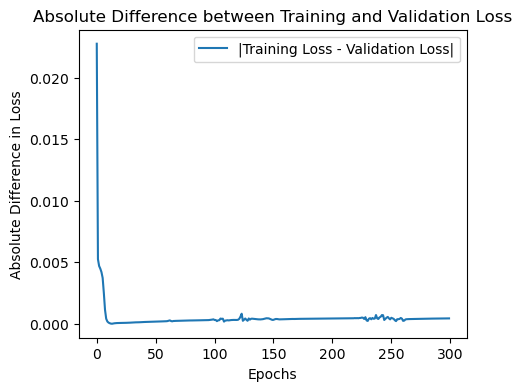

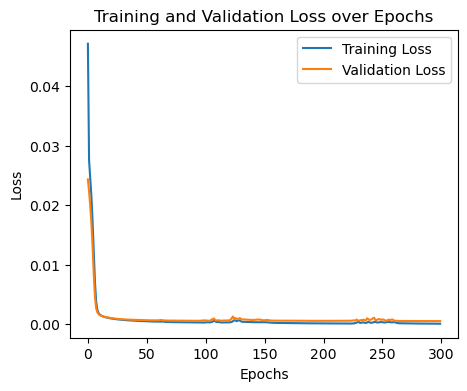

In [6]:
# Set model architecture
hidden1 = 235  # FC1, 235 units
hidden2 = 380  # FC2, 380 units
input_features = X_train.shape[-1]  # Input layer, size 8
output_features = y_train.shape[-1]  # Output, size 4

model = FNN(
    in_features=input_features, 
    hidden_size1=hidden1, 
    hidden_size2=hidden2,
    out_features=output_features
)

epochs = 300
lr = 0.0005
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

# Start time
start = time.time()
train_losses, val_losses = train_model(model, train_loader, val_loader, epochs, criterion, optimizer)
end = time.time()
training_time = end - start
print(f"Training took {training_time:.4f} seconds")

# Plot the training and validation losses
plot_losses(train_losses, val_losses, scale='linear', difference=True)
plot_losses(train_losses, val_losses, scale='linear')

In [7]:
def predict(model, test_loader, scaler_y=None, device=torch.device('cpu')):
    model.eval()  # Set the model to evaluation mode
    
    all_predictions = []
    true_values = []

    # Disable gradient computation for inference
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Store true values for comparison
            true_values.append(targets.cpu().numpy())

            # Generate predictions for each input
            outputs = model(inputs)

            # Store predictions
            all_predictions.append(outputs.cpu().numpy())

    # Concatenate predictions and true values across all batches
    all_predictions = np.concatenate(all_predictions, axis=0)  # Shape: (total_samples, num_outputs)
    true_values = np.concatenate(true_values, axis=0)  # Shape: (total_samples, num_outputs)

    # Apply inverse scaling if scaler_y is provided
    if scaler_y is not None:
        true_values = scaler_y.inverse_transform(true_values)
        all_predictions = scaler_y.inverse_transform(all_predictions)

    return all_predictions, true_values

In [8]:
test_predictions, test_actuals = predict(model, test_loader, scaler_y=Yscaler, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

print("Test Predictions:", test_predictions.shape)
print("Test Actuals:", test_actuals.shape)

Test Predictions: (451, 4)
Test Actuals: (451, 4)


In [11]:
def save_arrays_to_csv(array1: np.ndarray, array2: np.ndarray, filename: str):
    # Create a DataFrame from the three arrays
    df = pd.DataFrame({
        'True Flux Q1': array1[:, 0],
        'True Flux Q2': array1[:, 1],
        'True Flux Q3': array1[:, 2],
        'True Flux Q4': array1[:, 3],
        'Predicted Flux Q1': array2[:, 0],
        'Predicted Flux Q2': array2[:, 1],
        'Predicted Flux Q3': array2[:, 2],
        'Predicted Flux Q4': array2[:, 3]
    })

    # Save the DataFrame to a CSV file
    df.to_csv(filename, index=False)


save_arrays_to_csv(test_actuals, test_predictions, 'FNNTest.csv')

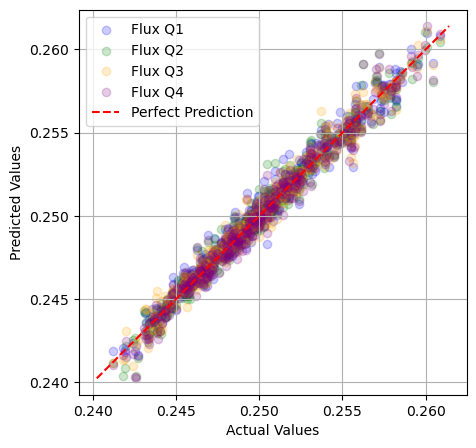

In [9]:
def plot_diagonal_validation(actuals, predictions):
    colors = ['blue', 'green', 'orange', 'purple']  # Colors for each column
    plt.figure(figsize=(5, 5))
    
    # Scatter plot of actuals vs. predictions
    #plt.scatter(actuals, predictions, alpha=0.3, label="Predictions")

    # Plot each column with a different color
    for i in range(actuals.shape[1]):
        plt.scatter(
            actuals[:, i], 
            predictions[:, i],
            alpha=0.2,
            label=f"Flux Q{i + 1}", 
            color=colors[i]
        )
    
    # Diagonal line (perfect predictions)
    min_val = min(np.min(actuals), np.min(predictions))
    max_val = max(np.max(actuals), np.max(predictions))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Perfect Prediction")
    
    # Add labels, title, and legend
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.legend()
    plt.grid(True)
    plt.axis("equal")  # Equal scaling for x and y axes
    plt.show()

plot_diagonal_validation(test_actuals, test_predictions)

In [10]:
# Calculate MAPE and RMSPE for each output
r2_scores = [r2_score(test_actuals[:, i], test_predictions[:, i]) for i in range(output_features)]
mae_scores = [mean_absolute_error(test_actuals[:, i], test_predictions[:, i]) for i in range(output_features)]
rmse_scores = [np.sqrt(mean_squared_error(test_actuals[:, i], test_predictions[:, i])) for i in range(output_features)]
mape_scores = [np.mean(np.abs((test_actuals[:, i] - test_predictions[:, i]) / test_actuals[:, i])) * 100 for i in range(output_features)]
rmspe_scores = [np.sqrt(np.mean(((test_actuals[:, i] - test_predictions[:, i]) / (test_actuals[:, i])) ** 2)) * 100 for i in range(output_features)]

print(f"R2: {r2_scores}")
print(f"MAE: {mae_scores}")
print(f"RMSE: {rmse_scores}")
print(f"MAPE: {mape_scores}")
print(f"RMSPE: {rmspe_scores}")

R2: [0.9737657720340182, 0.9741002523527108, 0.977540589067825, 0.9747029850192944]
MAE: [0.00049040874, 0.00048150352, 0.00045775267, 0.0004764448]
RMSE: [0.0006559177, 0.0006521213, 0.0006081651, 0.0006456351]
MAPE: [0.19582135137170553, 0.19222621340304613, 0.18285623518750072, 0.19018416060134768]
RMSPE: [0.2613746328279376, 0.25958744809031487, 0.24242948275059462, 0.2570810494944453]
